Loading image: /home/dabe/Projects/HSLU/S4/ROBO/DUCKIE/Labyrinth/images/x_close.png
Image loaded successfully.
Displaying the resulting white mask (BGR Filter)...


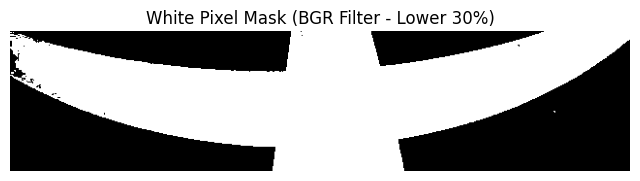

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
image_filename = 'images/x_close.png' # Path to your image
bottom_percentage = 30 # Analyze lower 30%
lower_color_bound = 130

# --- !!! RGB/BGR Thresholds !!! ---
# Remember OpenCV uses BGR order: [Blue, Green, Red]
# These values are VERY sensitive to lighting. Start high.
lower_bgr_white = np.array([lower_color_bound, lower_color_bound, lower_color_bound]) # Minimum B, G, R values
upper_bgr_white = np.array([255, 255, 255]) # Maximum B, G, R values

# --- Image Loading ---
image_path = os.path.abspath(image_filename)
print(f"Loading image: {image_path}")
original_image_bgr = cv2.imread(image_path)

# --- Image Processing ---
if original_image_bgr is None:
    print(f"Error: Could not load image '{image_filename}'. Check path and file.")
else:
    print("Image loaded successfully.")
    height, width, _ = original_image_bgr.shape

    # Calculate crop region
    crop_height_pixels = int(height * (bottom_percentage / 100.0))
    start_row = height - crop_height_pixels

    # Crop image to lower region
    lower_region_bgr = original_image_bgr[start_row:height, :]

    # --- !!! Create White Mask using BGR !!! ---
    # Apply inRange directly to the BGR cropped image
    white_mask = cv2.inRange(lower_region_bgr, lower_bgr_white, upper_bgr_white)

    # --- Display Result ---
    print("Displaying the resulting white mask (BGR Filter)...")
    plt.figure(figsize=(8, 6)) # Adjust size as needed
    plt.imshow(white_mask, cmap='gray')
    plt.title(f"White Pixel Mask (BGR Filter - Lower {bottom_percentage}%)")
    plt.axis('off')
    plt.show()



In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob

try:
    import cv2.ximgproc
    XIMGPROC_AVAILABLE = True
except ImportError:
    XIMGPROC_AVAILABLE = False
    print("\nWarning: cv2.ximgproc not found. Skeletonization will be skipped in detection.")

# =============================================================================
# == Detector Class Definition (Check Forward Line Position) ==
# =============================================================================
class JunctionDirectionDetector:
    """
    Analyzes a binary mask. Detects junctions. Uses skeletonization + Hough lines.
    Filters lines near border. Classifies 'forward' only if line reaches top edge.
    """
    def __init__(self, current_heading="north", border_crop_pixels=10, angle_tolerance=25,
                 forward_top_threshold_px=50): # New parameter
        self.current_heading = current_heading
        self.heading_update_map = {
            "north": {"forward": "north", "left": "west", "right": "east"},
            "east":  {"forward": "east",  "left": "north", "right": "south"},
            "south": {"forward": "south", "left": "east", "right": "west"},
            "west":  {"forward": "west",  "left": "south", "right": "north"},
        }
        self.angle_tolerance = angle_tolerance
        self.border_crop_pixels = border_crop_pixels
        # --- How close to top edge a vertical line must be to count as 'forward' ---
        self.forward_top_threshold_px = forward_top_threshold_px

    def update_heading(self, turn_direction):
        """Updates heading based on a relative turn ('left' or 'right')."""
        if turn_direction == "forward": return
        if turn_direction in self.heading_update_map[self.current_heading]:
            self.current_heading = self.heading_update_map[self.current_heading][turn_direction]
        else:
             raise ValueError(f"Invalid turn direction '{turn_direction}'. Must be 'left' or 'right'.")

    def process_mask(self, input_mask, return_debug=False):
        """
        Processes binary mask. Filters border lines. Checks 'forward' line position.
        """
        if input_mask is None or input_mask.ndim != 2:
             print("  Error: Invalid mask input.")
             return (False, []) + ((None,) * 5 if return_debug else ())

        orig_height, orig_width = input_mask.shape[:2]
        center_x = orig_width / 2.0
        debug_data = {}

        # 1. Clean Mask
        kernel = np.ones((5, 5), np.uint8)
        mask_cleaned = cv2.morphologyEx(input_mask, cv2.MORPH_CLOSE, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)
        if return_debug: debug_data['mask_cleaned'] = mask_cleaned

        # 2. Detect Junction
        contours, _ = cv2.findContours(mask_cleaned.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_contour_area = 500
        large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
        if return_debug: debug_data['large_contours'] = large_contours

        junction_detected = False
        if not large_contours: pass
        elif len(large_contours) >= 2: junction_detected = True
        elif len(large_contours) == 1:
            x, y, w, h = cv2.boundingRect(large_contours[0])
            if w > orig_width * 0.5 or h > orig_height * 0.5: junction_detected = True

        # 3. Detect Directions
        skeleton, skeleton_edges, all_lines = None, None, None
        filtered_lines = []
        detected_cardinals = set()

        if XIMGPROC_AVAILABLE and np.sum(mask_cleaned) > 0 :
            _, binary_mask = cv2.threshold(mask_cleaned, 127, 255, cv2.THRESH_BINARY)
            if np.sum(binary_mask) > 0:
                skeleton = cv2.ximgproc.thinning(binary_mask)
                if return_debug: debug_data['skeleton'] = skeleton

                if skeleton is not None and np.sum(skeleton) > 0:
                    skeleton_edges = cv2.Canny(skeleton, 50, 150, apertureSize=3)
                    if return_debug: debug_data['skeleton_edges'] = skeleton_edges

                    hough_threshold = 15; min_line_len = 20; max_line_gap = 7
                    if skeleton_edges is not None and np.sum(skeleton_edges) > 0:
                        all_lines = cv2.HoughLinesP(skeleton_edges, rho=1, theta=np.pi/180,
                                                     threshold=hough_threshold,
                                                     minLineLength=min_line_len,
                                                     maxLineGap=max_line_gap)
                        if return_debug: debug_data['lines'] = all_lines # Store unfiltered

                        # Filter Lines Based on Border Proximity
                        if all_lines is not None:
                            crop = self.border_crop_pixels
                            # Define safe area boundaries based on ORIGINAL mask dimensions
                            min_y_safe = crop
                            max_y_safe = orig_height - crop
                            min_x_safe = crop
                            max_x_safe = orig_width - crop

                            for line in all_lines:
                                x1, y1, x2, y2 = line[0]
                                # Keep line only if both endpoints are within the safe zone
                                if (min_y_safe <= y1 <= max_y_safe and min_x_safe <= x1 <= max_x_safe and
                                    min_y_safe <= y2 <= max_y_safe and min_x_safe <= x2 <= max_x_safe):
                                    filtered_lines.append(line)

                            # --- Classify directions using filtered lines AND forward position check ---
                            for line in filtered_lines:
                                x1, y1, x2, y2 = line[0]
                                angle_rad = math.atan2((y1-y2), (x2-x1))
                                angle_deg = math.degrees(angle_rad) % 360
                                mid_x = (x1 + x2) / 2.0

                                relative_dir = None

                                # Check Vertical Angle
                                is_vertical = (abs(angle_deg - 90) <= self.angle_tolerance or \
                                               abs(angle_deg - 270) <= self.angle_tolerance)

                                # Check Horizontal Angle
                                is_horizontal = (abs(angle_deg - 0) <= self.angle_tolerance or \
                                                 abs(angle_deg - 360) <= self.angle_tolerance or \
                                                 abs(angle_deg - 180) <= self.angle_tolerance)

                                if is_vertical:
                                    # --- ADDED CHECK: Must be near top edge to be 'forward' ---
                                    # y coordinates are relative to the top of mask_cleaned (0 is top)
                                    is_near_top = (y1 < self.forward_top_threshold_px or \
                                                   y2 < self.forward_top_threshold_px)
                                    if is_near_top:
                                        relative_dir = "forward"
                                    # Else: It's vertical but not near the top, likely the entry path - ignore it.

                                elif is_horizontal:
                                    # Positional check relative to original center for left/right
                                    relative_dir = "left" if mid_x < center_x else "right"

                                # Map valid relative directions to global cardinal
                                if relative_dir:
                                    global_cardinal = self.heading_update_map[self.current_heading].get(relative_dir)
                                    if global_cardinal: detected_cardinals.add(global_cardinal)

        else: # Handle cases where skeletonization is skipped
            if not XIMGPROC_AVAILABLE: print("  Warning: Skeletonization skipped.")
            elif np.sum(mask_cleaned)==0: print("  Warning: Mask empty after cleaning.")

        directions = sorted(list(detected_cardinals))

        if return_debug:
             # Return filtered_lines used for classification
            return (junction_detected, directions,
                    debug_data.get('mask_cleaned'), debug_data.get('skeleton'),
                    debug_data.get('skeleton_edges'), filtered_lines,
                    debug_data.get('large_contours'))
        else:
            return junction_detected, directions

Searching for images in: /home/dabe/Projects/HSLU/S4/ROBO/DUCKIE/Labyrinth/images
Found 16 images to process.

--- Processing: J_close.png ---
  Junction Detected: True
  Available Directions: ['north', 'west']
  Displaying debug plots...


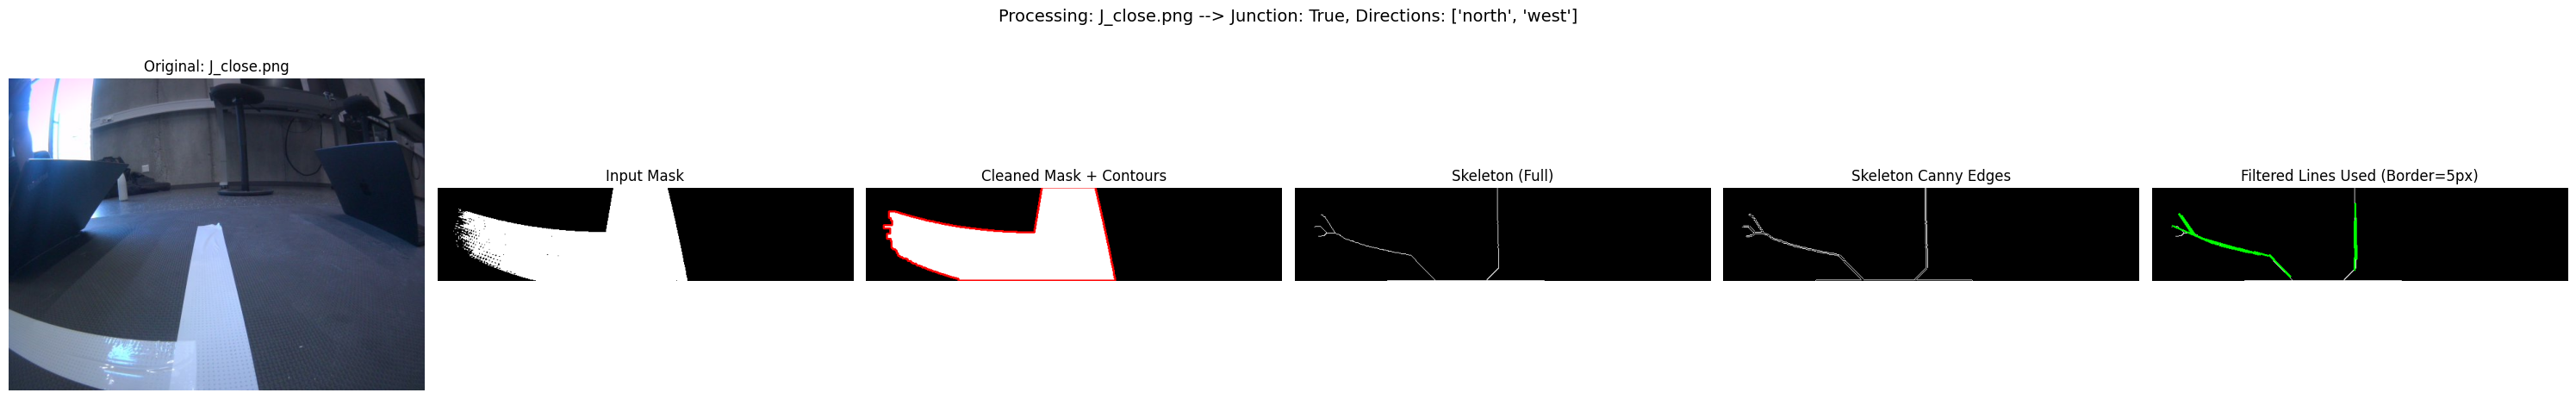


--- Processing: J_far.png ---
  Junction Detected: True
  Available Directions: ['north']
  Displaying debug plots...


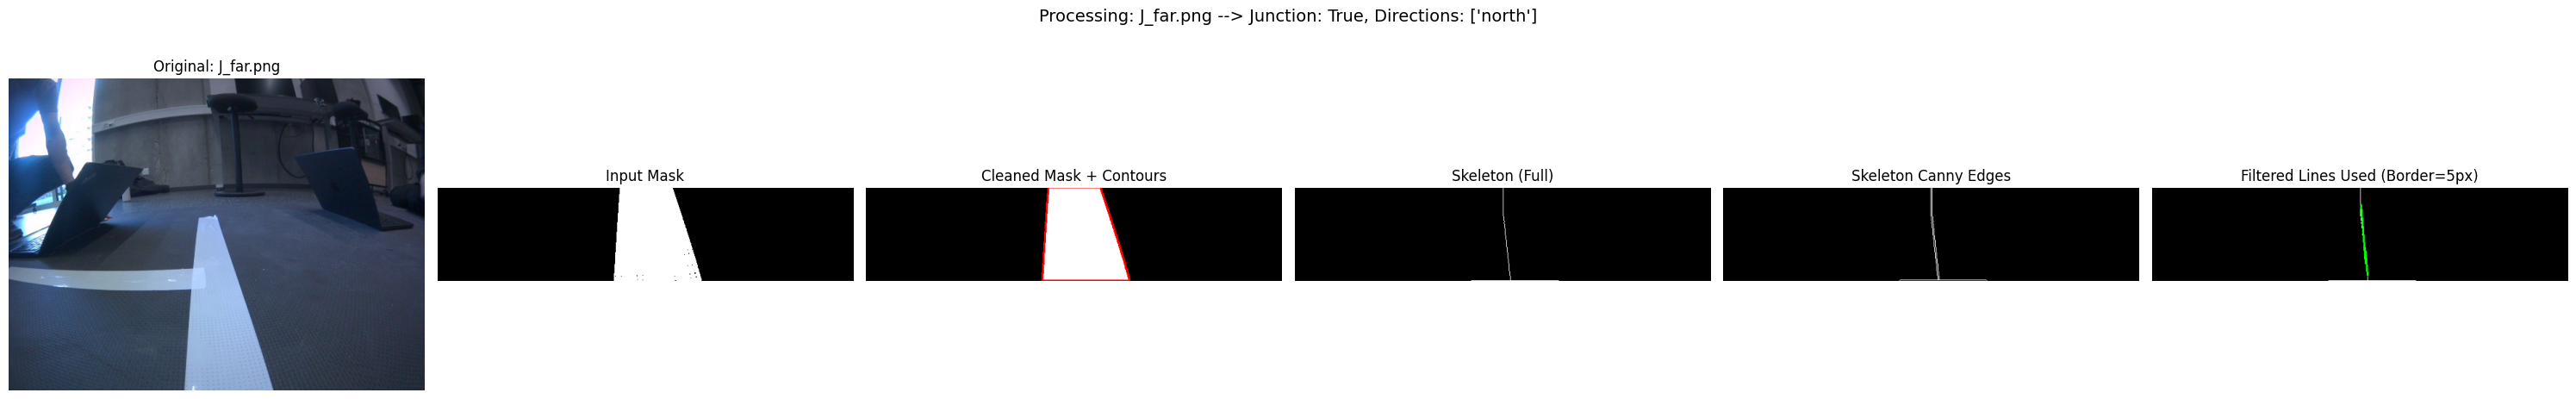


--- Processing: T_close.png ---
  Junction Detected: True
  Available Directions: ['east', 'west']
  Displaying debug plots...


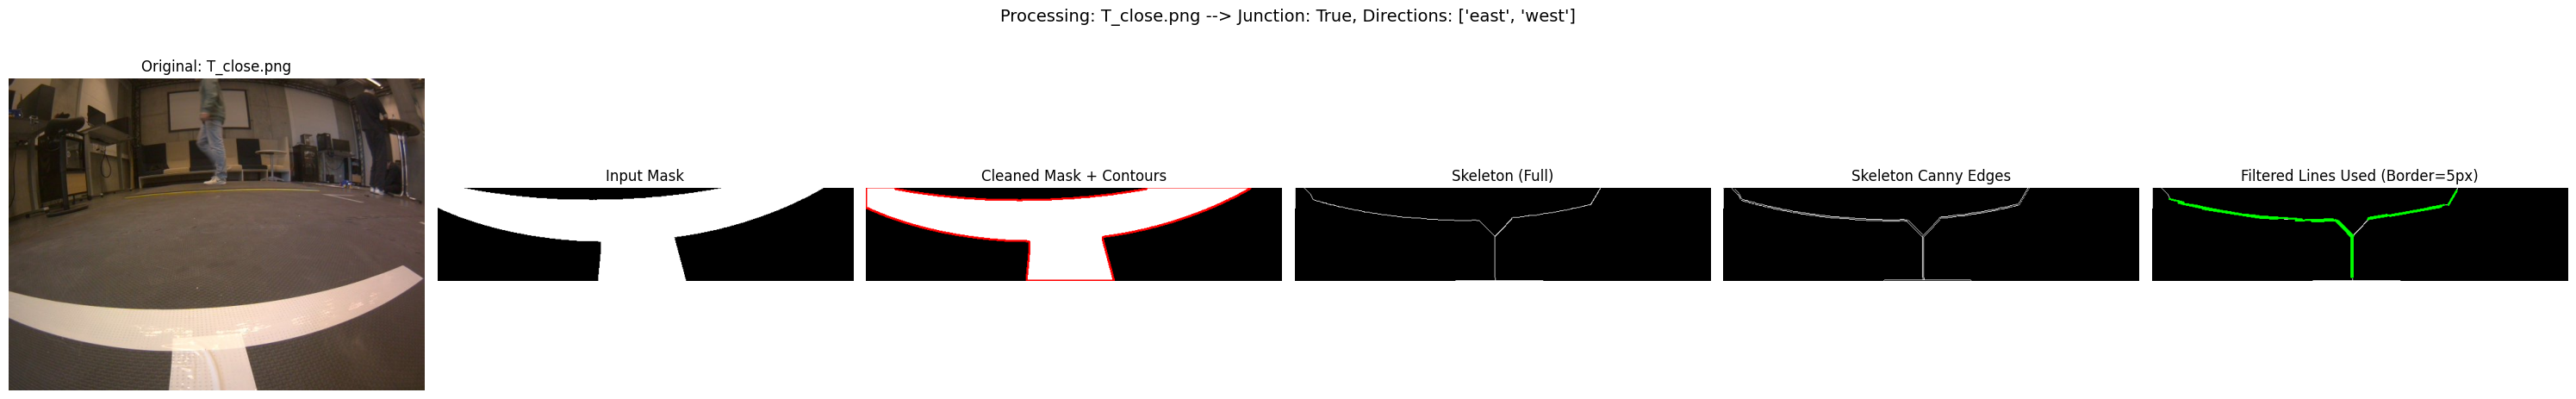


--- Processing: T_far.png ---
  Error: Could not load image 'T_far.png'. Skipping.

--- Processing: T_very-close.png ---
  Junction Detected: True
  Available Directions: ['east', 'west']
  Displaying debug plots...


libpng error: Read Error


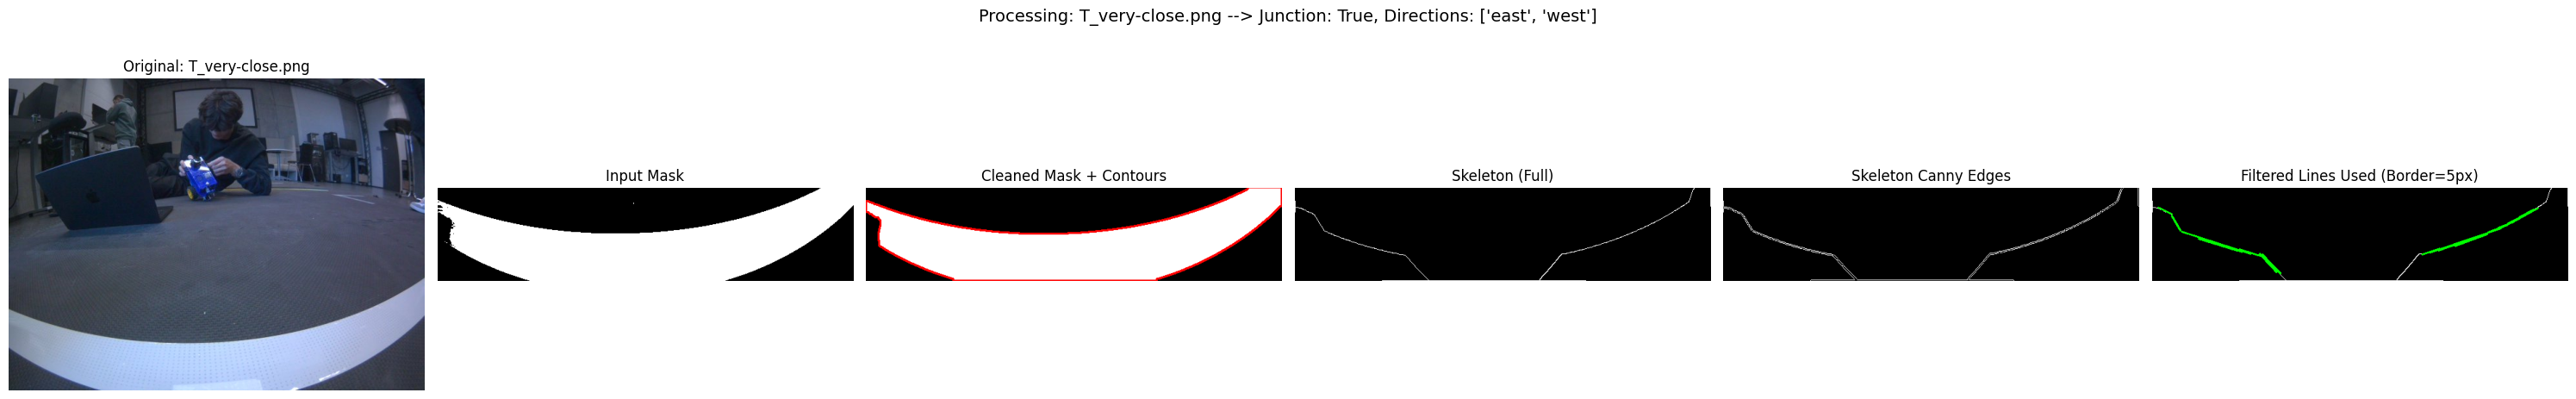


--- Processing: dead_1.png ---
  Junction Detected: True
  Available Directions: []
  Displaying debug plots...


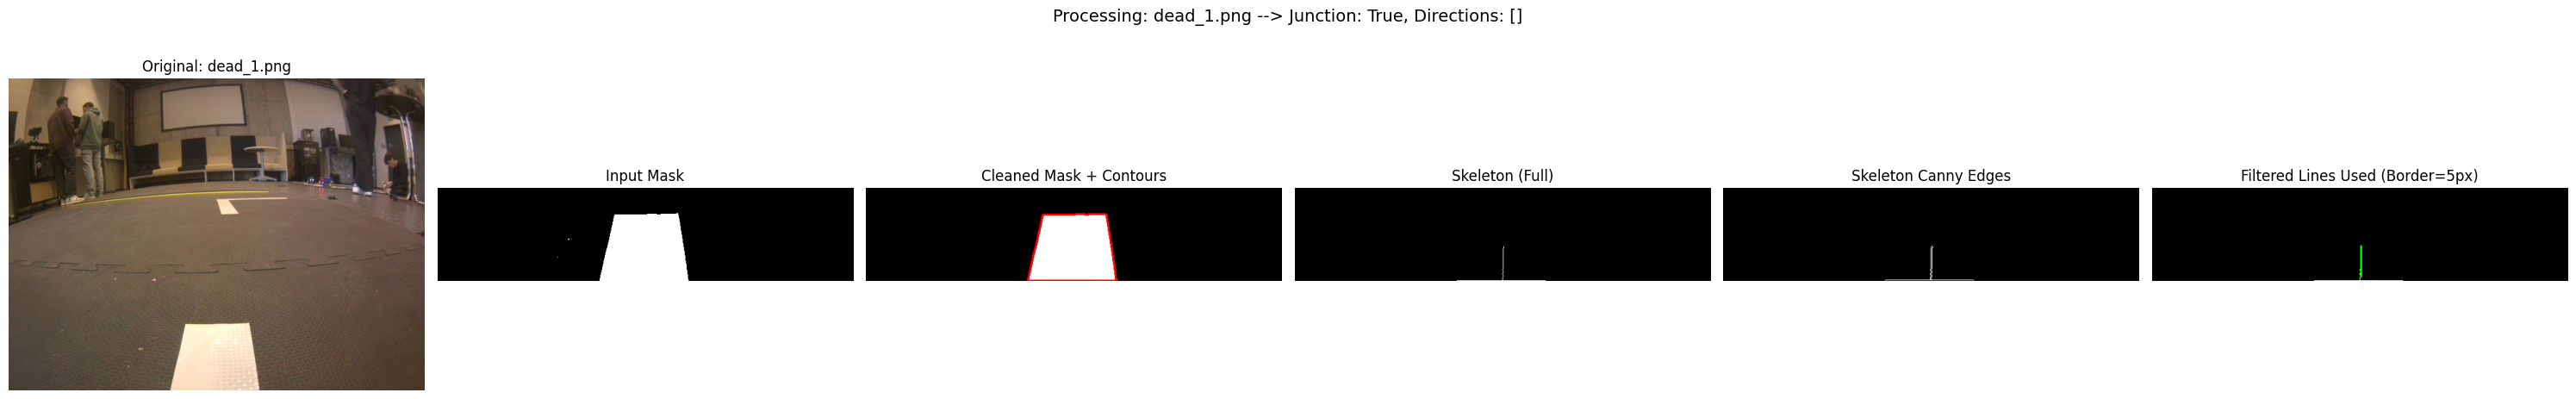


--- Processing: dead_2.png ---
  Junction Detected: False
  Available Directions: []
  Displaying debug plots...


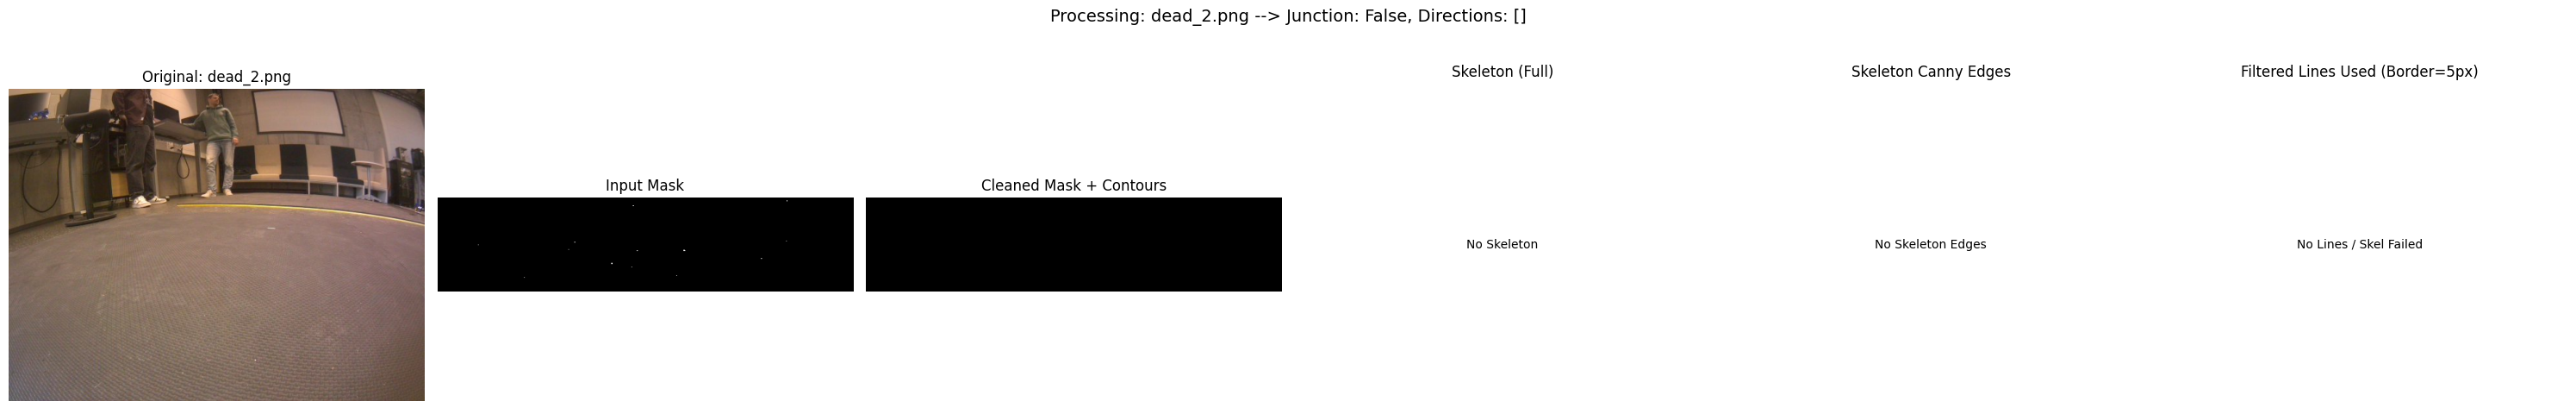


--- Processing: one_close.png ---
  Junction Detected: True
  Available Directions: ['west']
  Displaying debug plots...


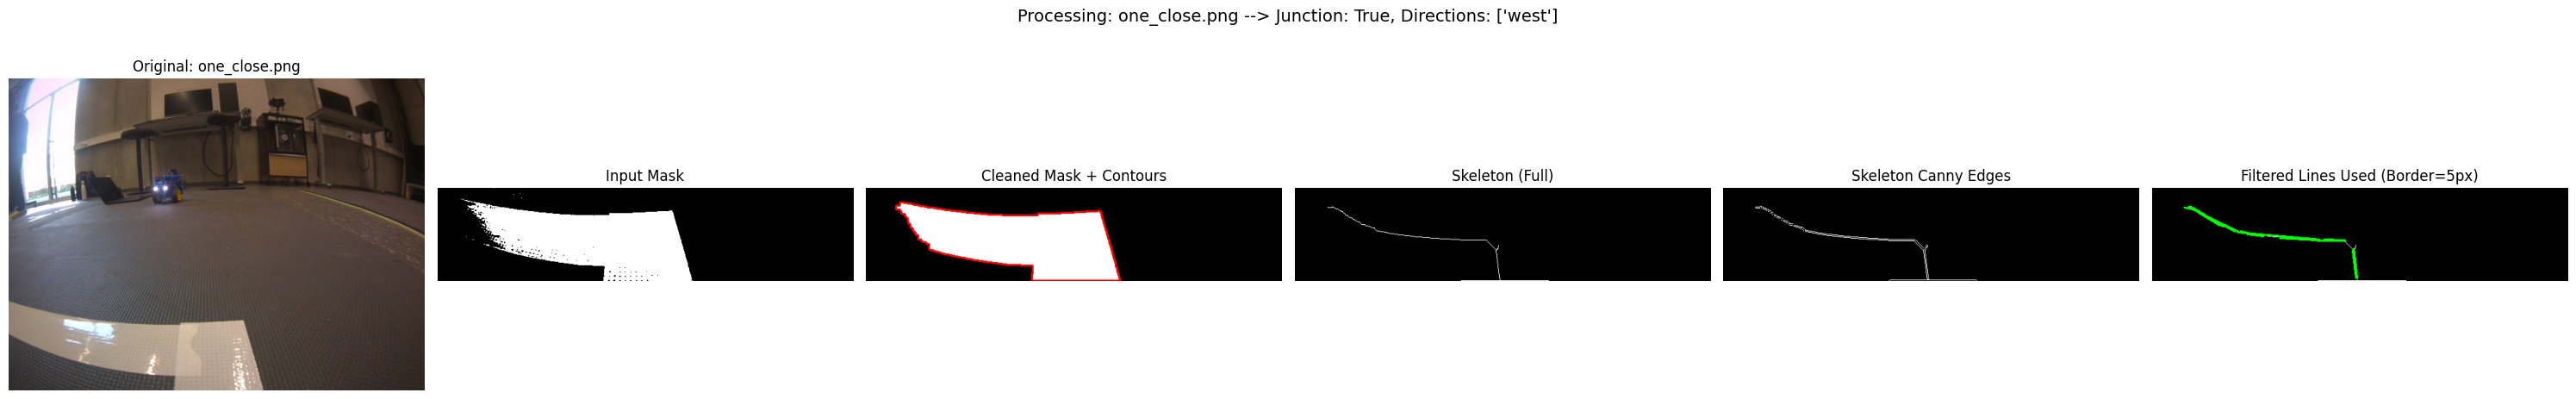


--- Processing: one_far.png ---
  Junction Detected: True
  Available Directions: ['north']
  Displaying debug plots...


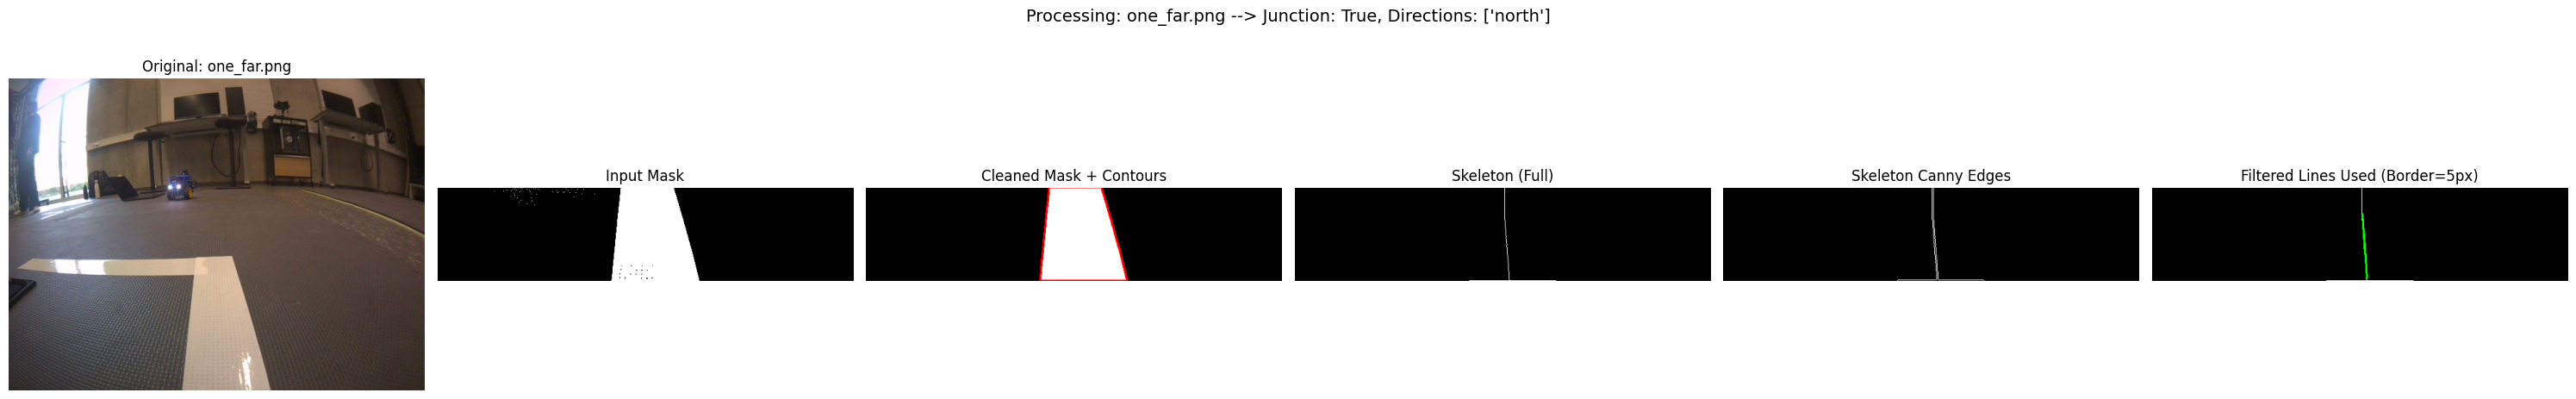


--- Processing: one_very.close.png ---
  Junction Detected: True
  Available Directions: ['west']
  Displaying debug plots...


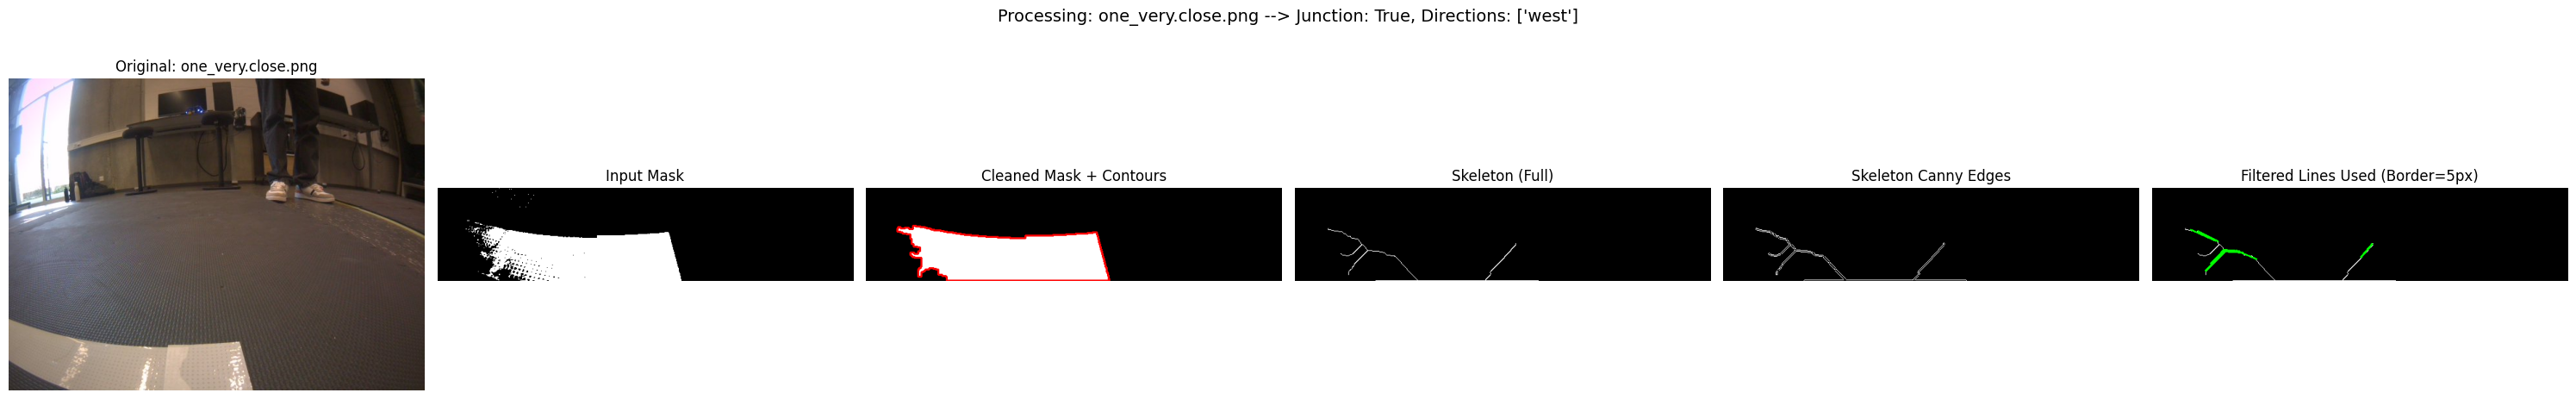


--- Processing: straight.png ---
  Junction Detected: True
  Available Directions: []
  Displaying debug plots...


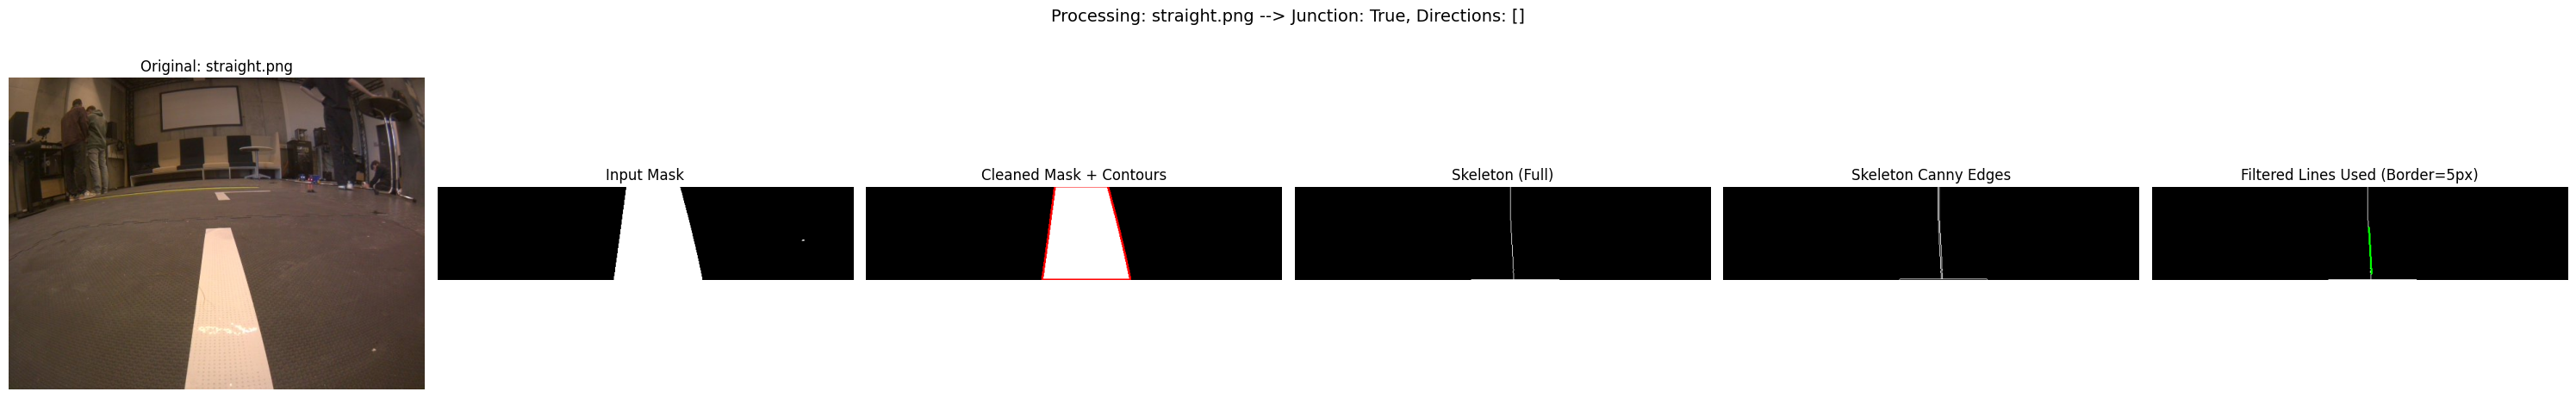


--- Processing: two_close.png ---
  Junction Detected: True
  Available Directions: ['east', 'west']
  Displaying debug plots...


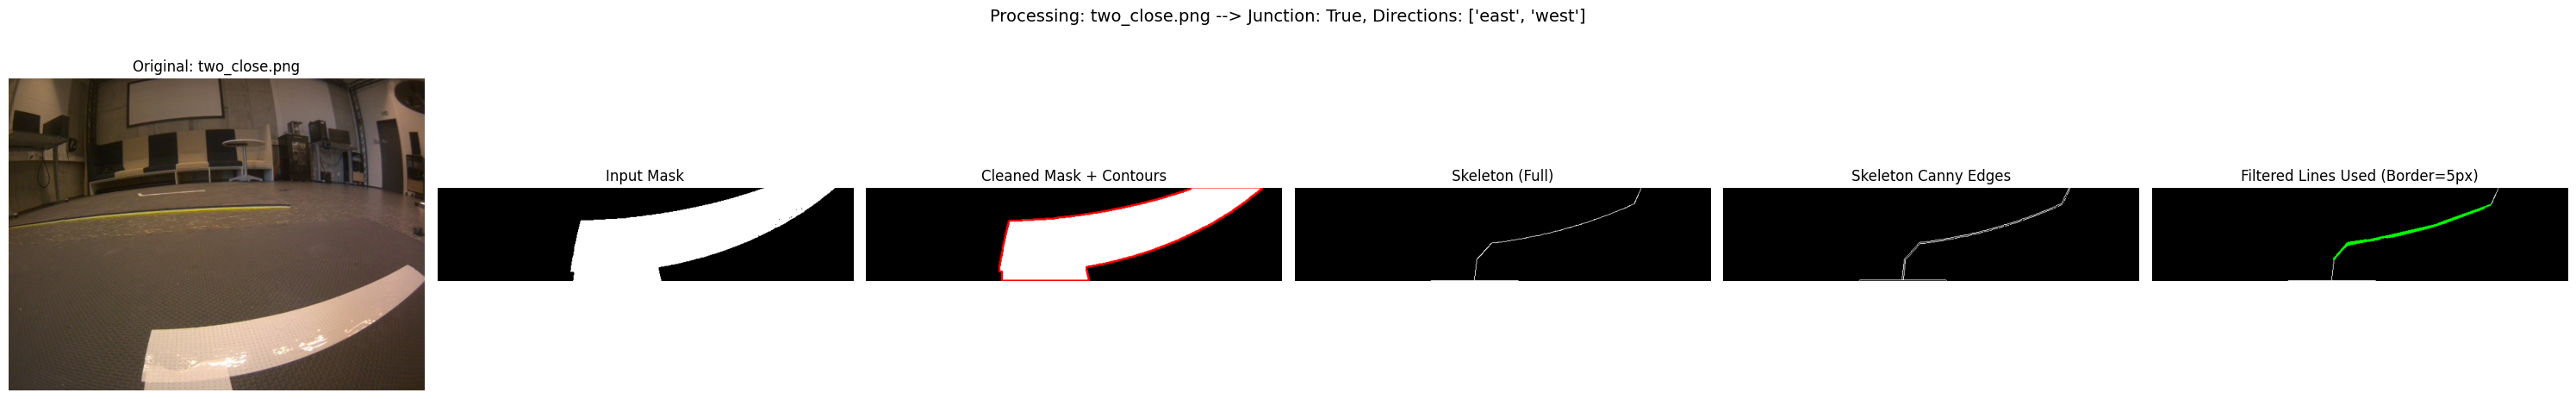


--- Processing: two_far.png ---
  Junction Detected: True
  Available Directions: ['north']
  Displaying debug plots...


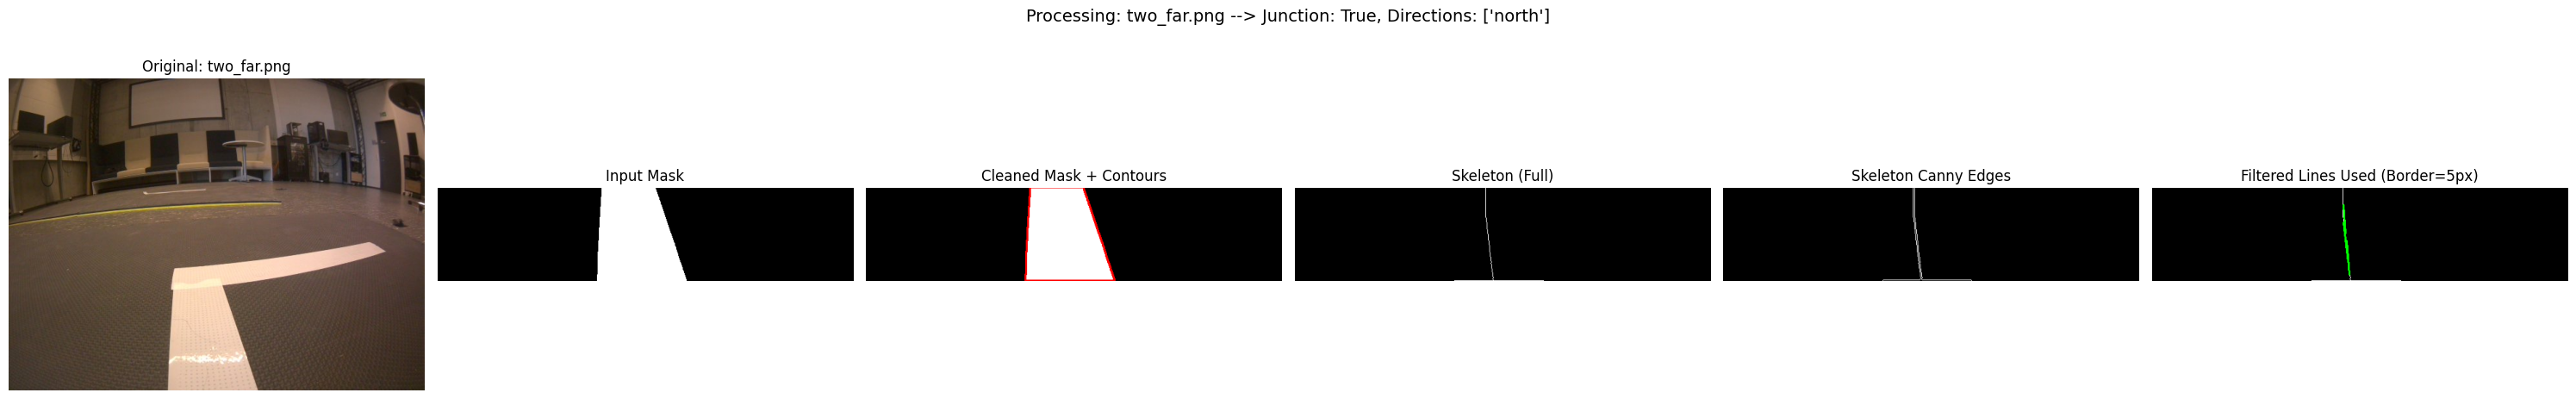


--- Processing: two_very-close.png ---
  Junction Detected: True
  Available Directions: []
  Displaying debug plots...


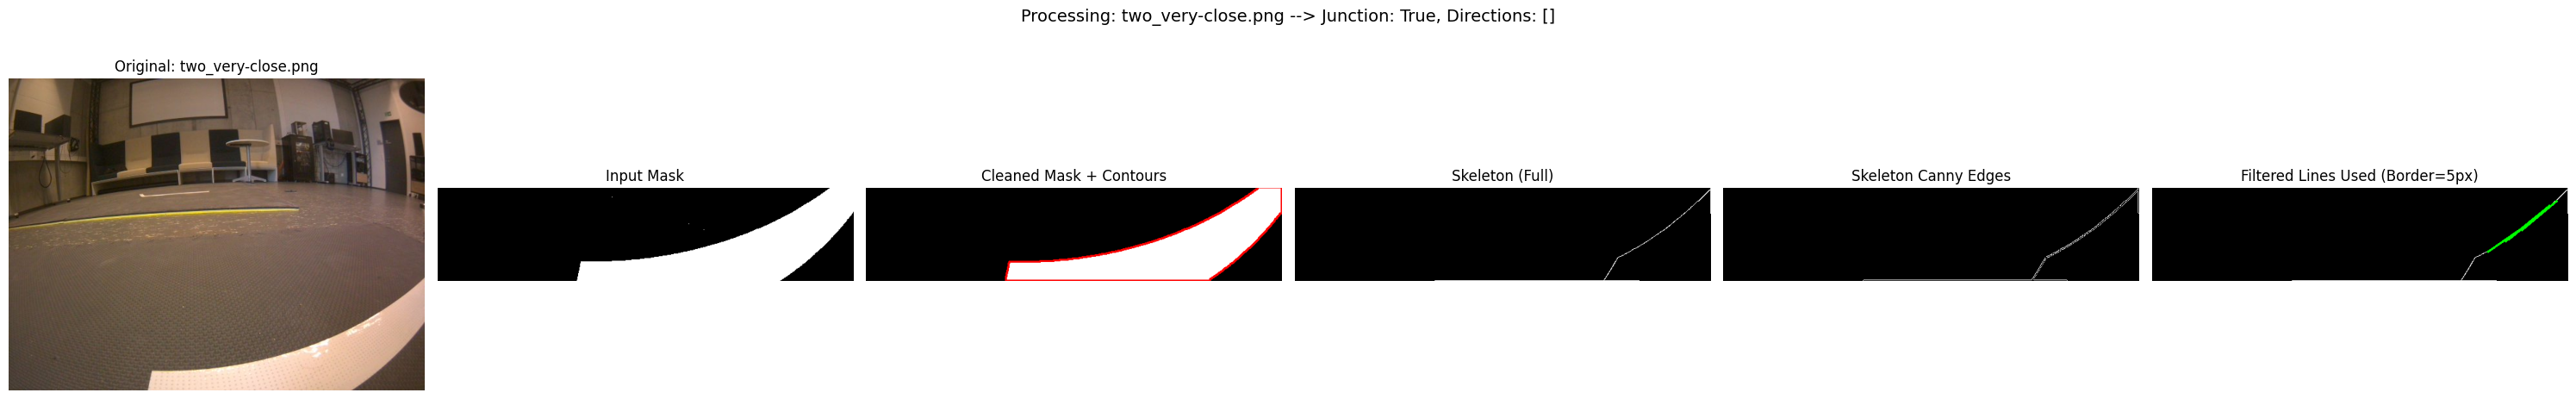


--- Processing: x_close.png ---
  Junction Detected: True
  Available Directions: ['east', 'north', 'west']
  Displaying debug plots...


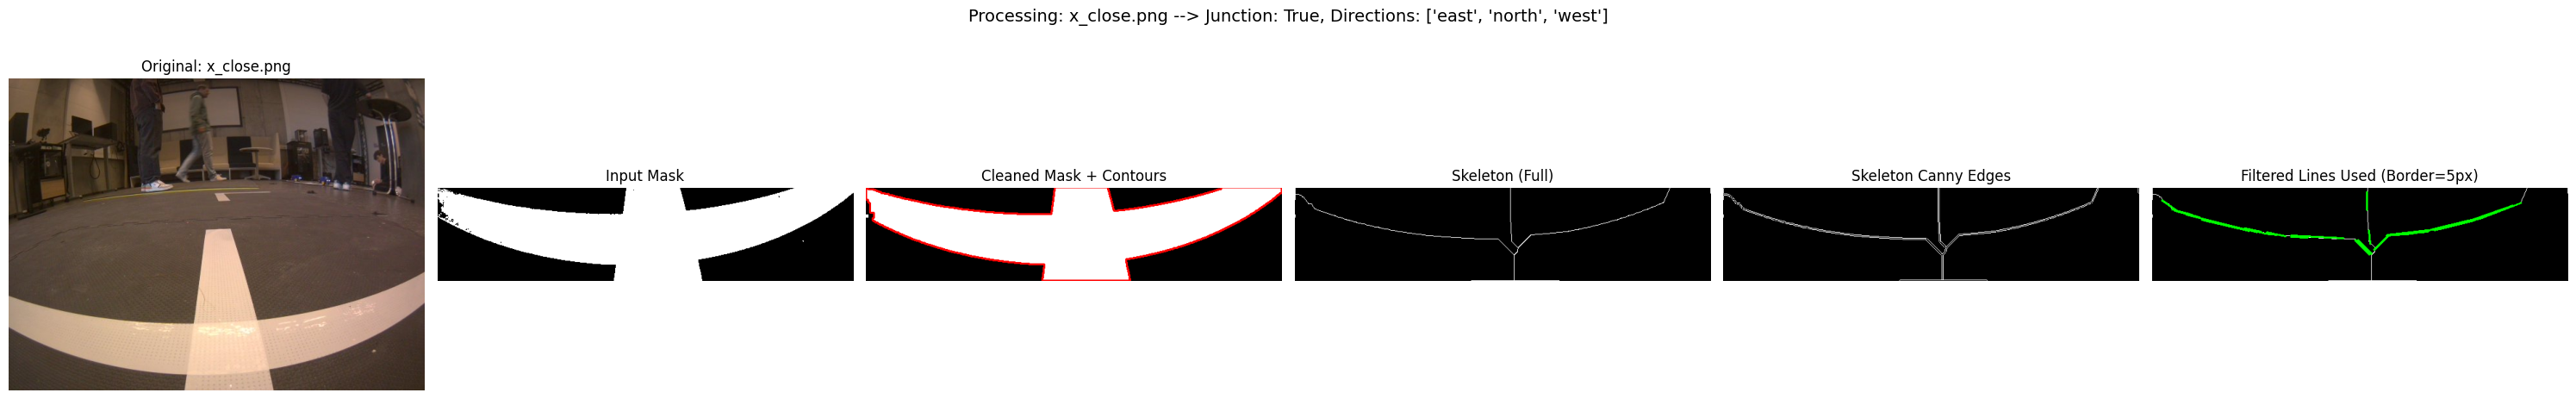


--- Processing: x_far.png ---
  Junction Detected: True
  Available Directions: []
  Displaying debug plots...


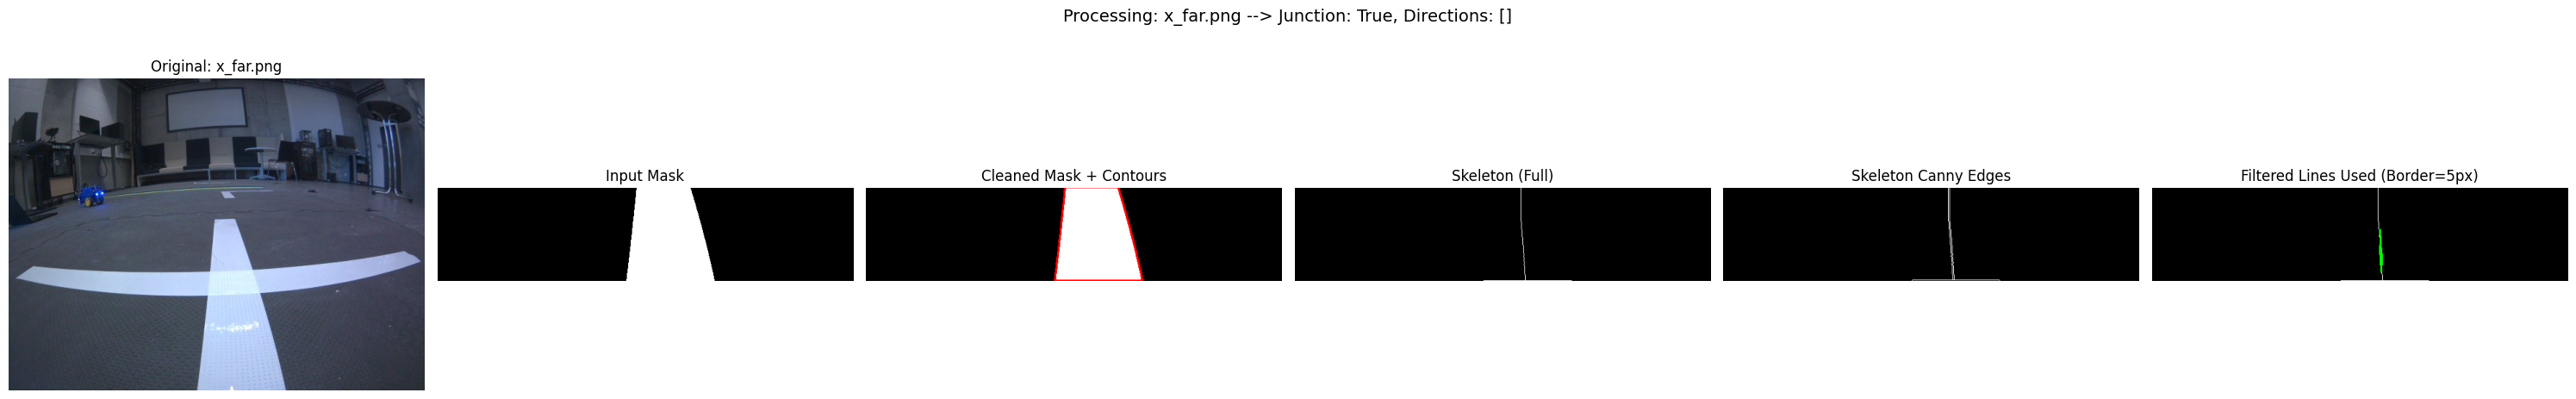


--- Batch processing finished. ---


In [13]:
import glob
# =============================================================================
# == Batch Testing Code (Adjusted for new parameter) ==
# =============================================================================

# --- Configuration ---
images_directory = 'images'
valid_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff']
bottom_percentage = 30
lower_color_bound = 130
initial_robot_heading = "north"
detector_border_crop = 5
detector_angle_tol = 25
detector_forward_thresh = 50 # How close to top edge (pixels) vertical line must be

# --- Find Image Files ---
# ... (glob code remains the same) ...
image_files = []
print(f"Searching for images in: {os.path.abspath(images_directory)}")
for ext in valid_extensions:
    image_files.extend(glob.glob(os.path.join(images_directory, f'*{ext}'), recursive=False))
    image_files.extend(glob.glob(os.path.join(images_directory, f'*{ext.upper()}'), recursive=False))

image_files = sorted(list(set(image_files)))

if not image_files:
    print(f"Error: No image files found in '{images_directory}' with extensions: {valid_extensions}")
else:
    print(f"Found {len(image_files)} images to process.")

    # --- Loop Through Each Image ---
    for image_path in image_files:
        print(f"\n--- Processing: {os.path.basename(image_path)} ---")

        # 1. Load Image
        original_image_bgr = cv2.imread(image_path)
        if original_image_bgr is None:
            print(f"  Error: Could not load image '{os.path.basename(image_path)}'. Skipping.")
            continue

        # 2. Generate White Mask
        height, width, _ = original_image_bgr.shape
        crop_height_pixels = int(height * (bottom_percentage / 100.0))
        start_row = max(0, height - crop_height_pixels)
        lower_region_bgr = original_image_bgr[start_row:height, :]

        white_mask = None
        if lower_region_bgr.shape[0] > 0 and lower_region_bgr.shape[1] > 0:
            lower_bgr = np.array([lower_color_bound] * 3)
            upper_bgr = np.array([255] * 3)
            white_mask = cv2.inRange(lower_region_bgr, lower_bgr, upper_bgr)

        if white_mask is None or np.sum(white_mask) == 0:
            print("  Mask generation failed or resulted in an empty mask. Skipping detection.")
            plt.figure(figsize=(6, 4)); plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)); plt.title(f"{os.path.basename(image_path)}\n(Mask Failed)"); plt.axis('off'); plt.show()
            continue

        # 3. Process Mask with a NEW Detector Instance and get Debug Data
        detector = JunctionDirectionDetector(
            current_heading=initial_robot_heading,
            border_crop_pixels=detector_border_crop,
            angle_tolerance=detector_angle_tol,
            forward_top_threshold_px = detector_forward_thresh # Pass new threshold
        )
        results = detector.process_mask(white_mask, return_debug=True)
        (junction_detected, directions, mask_cleaned, skeleton,
         skel_edges, filtered_lines, contours) = results

        # 4. Print Results
        print(f"  Junction Detected: {junction_detected}")
        print(f"  Available Directions: {directions}") # This should now exclude incoming 'north'

        # --- 5. Display Debug Visualizations ---
        print("  Displaying debug plots...")
        original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

        mask_vis_contours = None
        if mask_cleaned is not None:
             mask_vis_contours = cv2.cvtColor(mask_cleaned, cv2.COLOR_GRAY2BGR)
             if contours: cv2.drawContours(mask_vis_contours, contours, -1, (0, 0, 255), 2)

        skel_vis_lines = None
        if skeleton is not None:
             skel_vis_lines = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
             if filtered_lines is not None: # Draw the lines that passed border filter
                 for line in filtered_lines: cv2.line(skel_vis_lines, tuple(line[0][:2]), tuple(line[0][2:]), (0, 255, 0), 2) # Green

        num_plots = 6 if XIMGPROC_AVAILABLE else 3
        plt.figure(figsize=(5 * num_plots, 5))
        plot_idx = 1

        # Plot 1: Original Image
        plt.subplot(1, num_plots, plot_idx); plot_idx += 1
        plt.imshow(original_image_rgb); plt.title(f"Original: {os.path.basename(image_path)}"); plt.axis('off')

        # Plot 2: Input Mask
        plt.subplot(1, num_plots, plot_idx); plot_idx += 1
        plt.imshow(white_mask, cmap='gray'); plt.title("Input Mask"); plt.axis('off')

        # Plot 3: Cleaned Mask + Contours
        plt.subplot(1, num_plots, plot_idx); plot_idx += 1
        if mask_vis_contours is not None: plt.imshow(cv2.cvtColor(mask_vis_contours, cv2.COLOR_BGR2RGB)); plt.title("Cleaned Mask + Contours")
        else: plt.text(0.5, 0.5, 'Cleaned Mask Failed', ha='center', va='center'); plt.title("Cleaned Mask + Contours")
        plt.axis('off')

        if XIMGPROC_AVAILABLE:
            # Plot 4: Skeleton (Full)
            plt.subplot(1, num_plots, plot_idx); plot_idx += 1
            if skeleton is not None: plt.imshow(skeleton, cmap='gray'); plt.title("Skeleton (Full)")
            else: plt.text(0.5, 0.5, 'No Skeleton', ha='center', va='center'); plt.title("Skeleton (Full)")
            plt.axis('off')

            # Plot 5: Skeleton Edges
            plt.subplot(1, num_plots, plot_idx); plot_idx += 1
            if skel_edges is not None: plt.imshow(skel_edges, cmap='gray'); plt.title("Skeleton Canny Edges")
            else: plt.text(0.5, 0.5, 'No Skeleton Edges', ha='center', va='center'); plt.title("Skeleton Canny Edges")
            plt.axis('off')

            # Plot 6: Filtered Lines Used for Classification
            plt.subplot(1, num_plots, plot_idx); plot_idx += 1
            if skel_vis_lines is not None: plt.imshow(cv2.cvtColor(skel_vis_lines, cv2.COLOR_BGR2RGB)); plt.title(f"Filtered Lines Used (Border={detector_border_crop}px)")
            else: plt.text(0.5, 0.5, 'No Lines / Skel Failed', ha='center', va='center'); plt.title(f"Filtered Lines Used (Border={detector_border_crop}px)")
            plt.axis('off')

        plt.suptitle(f"Processing: {os.path.basename(image_path)} --> Junction: {junction_detected}, Directions: {directions}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print("\n--- Batch processing finished. ---")